## 0. Import Library

In [1]:
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

## 1. Data Preparation

In [ ]:
corpus = [
    "ăn quả nhớ kẻ trồng cây",
    "có chí thì nên"
]

In [ ]:
data_size = len(corpus)

# Define the max vocabulary size and sequence length
vocab_size = 12
sequence_length = 5

In [ ]:
# Define tokenizer function
tokenizer = get_tokenizer('basic_english')

# Create a function to yield list of tokens
def yield_tokens(examples):
    for text in examples:
        yield tokenizer(text)

# Create vocabulary
vocab = build_vocab_from_iterator(yield_tokens(corpus),
                                  max_tokens=vocab_size,
                                  specials=["<unk>", "<pad>"]
                                 )
vocab.set_default_index(vocab["<unk>"])
vocab.get_stoi()

{'ăn': 11,
 'thì': 9,
 'nhớ': 6,
 'kẻ': 5,
 'trồng': 10,
 'quả': 8,
 'cây': 3,
 'chí': 2,
 '<pad>': 1,
 'nên': 7,
 'có': 4,
 '<unk>': 0}

In [ ]:
data_x = []
data_y = []
for vector in corpus:
    vector = vector.split()
    x = vector[:-1]
    y = vector[1:]

    for i in range(len(x)):
        data_x.append(x[:i+1])
        data_y.append(y[i])

print(data_x)
print(data_y)

[['ăn'], ['ăn', 'quả'], ['ăn', 'quả', 'nhớ'], ['ăn', 'quả', 'nhớ', 'kẻ'], ['ăn', 'quả', 'nhớ', 'kẻ', 'trồng'], ['có'], ['có', 'chí'], ['có', 'chí', 'thì']]
['quả', 'nhớ', 'kẻ', 'trồng', 'cây', 'chí', 'thì', 'nên']


In [ ]:
# Tokenize and numericalize your samples
def vectorize(x, y, vocab, sequence_length):
    x_ids = [vocab[token] for token in x][:sequence_length]
    x_ids = x_ids + [vocab["<pad>"]] * (sequence_length - len(x))
    return x_ids, vocab[y]

# Vectorize the samples
data_x_ids = []
data_y_ids = []
for x, y in zip(data_x, data_y):
    x_ids, y_ids = vectorize(x, y, vocab, sequence_length)
    data_x_ids.append(x_ids)
    data_y_ids.append(y_ids)

In [ ]:
for x, y in zip(data_x_ids, data_y_ids):
    print(x)
    print(y)
    print()

In [ ]:
data_x_ids = torch.tensor(data_x_ids, dtype=torch.long)
print(data_x_ids.shape)

In [ ]:
data_y_ids = torch.tensor(data_y_ids, dtype=torch.long)
print(data_y_ids.shape)

## 2. Model

In [ ]:
class Text_Generation_Model(nn.Module):
    def __init__(self, vocab_size, sequence_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 4)
        self.recurrent = nn.RNN(4, 4, batch_first=True)
        self.linear = nn.Linear(sequence_length*4, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x,_ = self.recurrent(x)
        x = nn.Flatten()(x)
        x = self.linear(x)
        return x

model = Text_Generation_Model(vocab_size, sequence_length)
print(model)

Text_Generation_Model(
  (embedding): Embedding(12, 4)
  (recurrent): RNN(4, 4, batch_first=True)
  (linear): Linear(in_features=20, out_features=12, bias=True)
)


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import  summary
input_data = torch.randint(low=0, high=vocab_size-1, size=(8, sequence_length))
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
Text_Generation_Model                    [8, 12]                   --
├─Embedding: 1-1                         [8, 5, 4]                 48
├─RNN: 1-2                               [8, 5, 4]                 40
├─Linear: 1-3                            [8, 12]                   252
Total params: 340
Trainable params: 340
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

## 4. Train model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
# train
EPOCH = 35
losses = []
for i in range(EPOCH):
    model.train()

    optimizer.zero_grad()

    outputs = model(data_x_ids)

    loss = criterion(outputs, data_y_ids)
    losses.append(loss.item())
    print(losses[i])

    loss.backward()
    optimizer.step()

2.616819143295288
2.2212626934051514
1.9182645082473755
1.6066248416900635
1.3070158958435059
1.0671733617782593
0.8633514642715454
0.6896437406539917
0.5530838370323181
0.44638389348983765
0.3593883514404297
0.2856554090976715
0.22318050265312195
0.17202647030353546
0.13212333619594574
0.10230690985918045
0.08040360361337662
0.06409619748592377
0.05160079896450043
0.04180564731359482
0.034062791615724564
0.02794945053756237
0.023139020428061485
0.01935836486518383
0.01638037897646427
0.014021423645317554
0.012137703597545624
0.010618370957672596
0.009379547089338303
0.008358362130820751
0.007507439702749252
0.006791687570512295
0.006184501573443413
0.005665775388479233
0.005220024846494198


In [ ]:
outputs = model(data_x_ids)
print(torch.argmax(outputs, axis=-1))

In [ ]:
data_y_ids

## 5. Inference

In [ ]:
promt = 'có chí'
promt = promt.split()
promt_ids = [vocab[token] for token in promt][:sequence_length]
promt_ids = promt_ids + [vocab["<pad>"]] * (sequence_length - len(promt))

print(promt_ids)

[4, 2, 1, 1, 1]


In [ ]:
for i in range(sequence_length - len(promt)):
    promt_tensor = torch.tensor(promt_ids, dtype=torch.long).reshape(1, -1)
    outputs = model(promt_tensor)
    next_id = torch.argmax(outputs, axis=-1)

    promt_ids[len(promt)+i] = next_id.item()
    print(promt_ids)

[4, 2, 9, 1, 1]
[4, 2, 9, 7, 1]
[4, 2, 9, 7, 7]


In [ ]:
{'ăn': 11,
 'thì': 9,
 'nhớ': 6,
 'kẻ': 5,
 'trồng': 10,
 'quả': 8,
 'cây': 3,
 'chí': 2,
 '<pad>': 1,
 'nên': 7,
 'có': 4,
 '<unk>': 0}

{'ăn': 11,
 'thì': 9,
 'nhớ': 6,
 'kẻ': 5,
 'trồng': 10,
 'quả': 8,
 'cây': 3,
 'chí': 2,
 '<pad>': 1,
 'nên': 7,
 'có': 4,
 '<unk>': 0}

## 6. Plot results

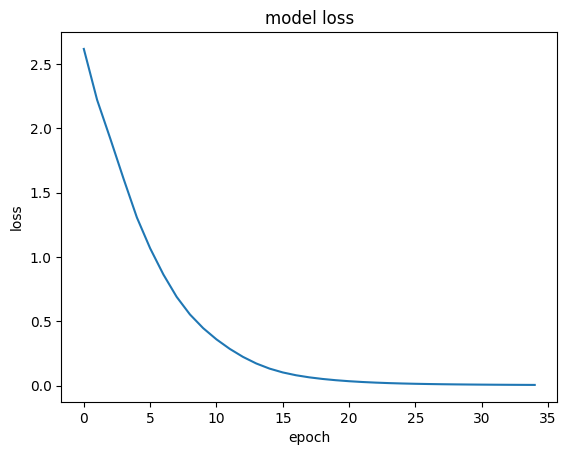

In [ ]:
plt.plot(losses, label='Train')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()